In [2]:
# standard library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import sys
%matplotlib inline
import matplotlib.pyplot as plt


# From this framework
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils


sys.path.append("../")
from data.objects.adult import Adult
from data.objects.ricci import Ricci
from data.objects.titanic import Titanic
from data.objects.compas import Compas
from data.objects.german import German


In [3]:
verbose = False
dataset_name = "compas"
if(dataset_name == "adult"):
    dataset = Adult(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "ricci"):
    dataset = Ricci(verbose=verbose, config=0) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "titanic"):
    dataset = Titanic(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "compas"):
    dataset = Compas(verbose=verbose, config=1) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "german"):
    dataset = German(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
else:
    raise ValueError()


# get X,y
X = df.drop(['target'], axis=1)
y = df['target']

print(dataset.known_sensitive_attributes)
print(X.columns)

# one-hot encoding for categorical features (this takes care of Label encoding automatically)
X = utils.get_one_hot_encoded_df(X,dataset.categorical_attributes)

X.head(10)

['race']
Index(['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree'],
      dtype='object')


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,0,0.653846,0,0.0,0.000000,0.000000,0.000000,0
1,0,0.205128,0,0.0,0.000000,0.000000,0.000000,0
2,0,0.076923,0,0.0,0.000000,0.058824,0.105263,0
3,0,0.064103,0,0.0,0.076923,0.000000,0.026316,0
4,0,0.320513,0,0.0,0.000000,0.000000,0.052632,0
5,0,0.333333,0,0.0,0.000000,0.000000,0.000000,1
6,0,0.294872,1,0.0,0.000000,0.000000,0.368421,0
7,0,0.320513,0,0.0,0.000000,0.000000,0.078947,0
8,1,0.269231,1,0.0,0.000000,0.000000,0.000000,1
9,0,0.038462,1,0.0,0.000000,0.000000,0.026316,0


In [4]:
clf = LogisticRegression()
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# clf = SVC()
clf.fit(X.values, y.values)

LogisticRegression()

## Fairness explanation using (co)variance decomposition

In [5]:
fairXplainer = FairXplainer(clf, X, dataset.known_sensitive_attributes)
fairXplainer.compute(maxorder=2, spline_intervals=6, verbose=False)

### Individual FIFs

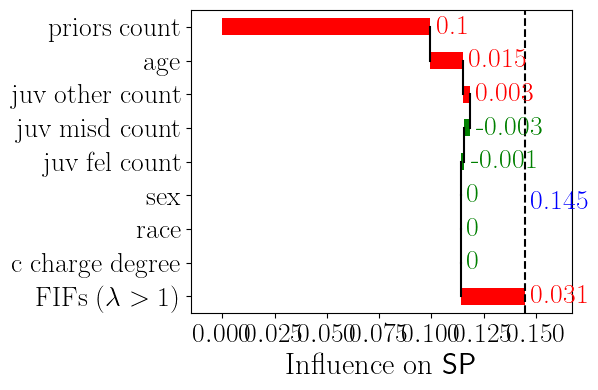

Exact statistical parity 0.1747909432721744


<Figure size 600x400 with 0 Axes>

In [6]:
result = fairXplainer.get_weights()

fontsize = 22
labelsize = 20

plt = fif_plot(result, draw_waterfall=True, labelsize=labelsize, figure_size=(6,4), text_y_pad=0.2, xlim=None, result_y_location=0.6,
            # title="FairXplainer, " + r"$\lambda = 1$",
            x_label="Influence on " + r"$ \mathsf{SP} $")
plt.show()
plt.clf()
print("Exact statistical parity", fairXplainer.statistical_parity_sample())

### Intersectional FIFs

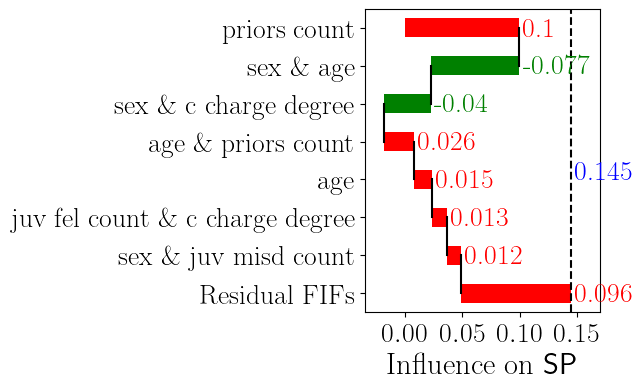

Exact statistical parity 0.1747909432721744


<Figure size 650x400 with 0 Axes>

In [7]:
k = 7
result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(result, draw_waterfall=True, labelsize=labelsize, figure_size=(6.5,4), text_y_pad=0.2, xlim=None, result_x_pad=0.02,
        # title="FairXplainer, " + r"$\lambda = 2$",
        x_label="Influence on " + r"$ \mathsf{SP} $")
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

### SHAP method

/Users/bishwamittraghosh/anaconda3/envs/test_fairxplainer/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
X has feature names, but LogisticRegression was fitted without feature names


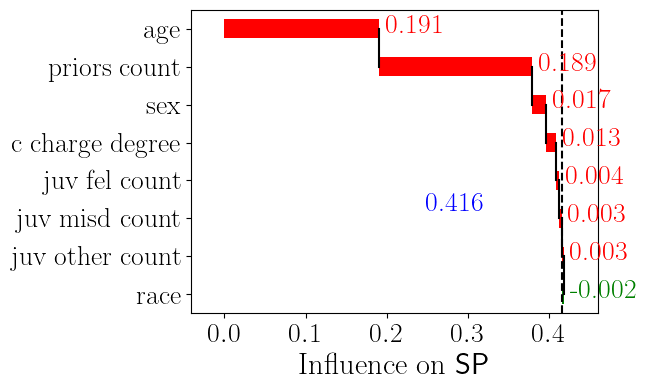

Exact statistical parity 0.1747909432721744


<Figure size 650x400 with 0 Axes>

In [8]:
from fairxplainer.wrapper.shap_fairness_explanation import ShapExplanation, row_masking_based_on_sensitive_groups
max_group_mask, min_group_mask = row_masking_based_on_sensitive_groups(clf, X, dataset.known_sensitive_attributes)
shapExplanation = ShapExplanation()
result_shap, exact_SP = shapExplanation.compute(clf, X, max_group_mask, min_group_mask, "lr", verbose=False)


plt = fif_plot(result_shap, draw_waterfall=True, labelsize=labelsize, figure_size=(6.5,4), result_y_location=0.6, result_x_pad=-0.4,
        x_label="Influence on " + r"$ \mathsf{SP} $")

plt.show()
plt.clf()

print("Exact statistical parity", exact_SP)